### import modules

In [1]:
import numpy as np
import pandas as pd
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline
# to remove depreciationWarning
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from pprint import pprint

- Import NLTK for common stop words
- This list of stopwords will be extended. The extension words are corpus specific

In [2]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['providing','amending','creating','barangay','regulating','granting','pesos','establishing','imposing','funds','office','public','guidelines','tagum', 'therefore', 'city', 'davao','ordinance','ii', 'penalties','nd','use','within','every','otherwise','thereof','section', 'municipal', 'municipality', 'government', 'series', 'continue', 'reading'])
# stop_words.extend(['ordinance','tagum','city','thereof','section','municipal','municipality','ii'])

### Import Tagum dataset

In [3]:
df = pd.read_csv('ordinances/tagum_ordinances.csv', header = 0)
print(df)
df.head()

                                     OR  \
0        CITY ORDINANCE No. 842, s-2018   
1        CITY ORDINANCE NO. 825, s-2017   
2        CITY ORDINANCE NO. 837, s-2018   
3        CITY ORDINANCE NO. 844, s-2018   
4        CITY ORDINANCE NO. 838, s-2018   
..                                  ...   
670  MUNICIPAL ORDINANCE NO. 05, s-1974   
671  MUNICIPAL ORDINANCE NO. 04, s-1974   
672  MUNICIPAL ORDINANCE NO. 01, s-1974   
673    MUNICIPAL ORDINANCE NO. 03, 1973   
674  MUNICIPAL ORDINANCE NO. 02, S-1973   

                                                    OT  
0    “AN ORDINANCE REGULATING THE PRACTICE OF TRADI...  
1    “AN ORDINANCE RECONSTITUTING THE MEMBERS OF TH...  
2    “AN ORDINANCE ESTABLISHING FUNERAL AND BURIAL ...  
3    AN ORDINANCE AMENDING THE TITLE, SECTION 1, SE...  
4    “AN ORDINANCE CREATING THE CITY HISTORICAL, CU...  
..                                                 ...  
670  “AN ORDINANCE AMENDING SECTION 10 OF MUNICIPAL...  
671  “AN ORDINANCE REGULATI

,OR,OT
0,"CITY ORDINANCE No. 842, s-2018",“AN ORDINANCE REGULATING THE PRACTICE OF TRADI...
1,"CITY ORDINANCE NO. 825, s-2017",“AN ORDINANCE RECONSTITUTING THE MEMBERS OF TH...
2,"CITY ORDINANCE NO. 837, s-2018",“AN ORDINANCE ESTABLISHING FUNERAL AND BURIAL ...
3,"CITY ORDINANCE NO. 844, s-2018","AN ORDINANCE AMENDING THE TITLE, SECTION 1, SE..."
4,"CITY ORDINANCE NO. 838, s-2018","“AN ORDINANCE CREATING THE CITY HISTORICAL, CU..."


Add ordinance descriptions to a list

In [4]:
data = list(df.OT) 
print(data[:1]) # preview

['“AN ORDINANCE REGULATING THE PRACTICE OF TRADITIONAL HOME BIRTH DELIVERY OR DELIVERIES ATTENDED BY A TRADITIONAL BIRTH ATTENDANT OR MANANABANG”.']


Use regular expression to remove words ending with ING.
(Seems to improve topics)

In [5]:
import re
data = [re.sub("\'", "", sent) for sent in data]
data = [re.sub("\"", "", sent) for sent in data]
# data = [re.sub('\S*ING\S*\s?', '', sent) for sent in data]

Tokenize and preprocess text

In [6]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

pprint(data_words[:1])

[['an',
  'ordinance',
  'regulating',
  'the',
  'practice',
  'of',
  'traditional',
  'home',
  'birth',
  'delivery',
  'or',
  'deliveries',
  'attended',
  'by',
  'traditional',
  'birth',
  'attendant',
  'or',
  'mananabang']]


In [7]:


# Remove Stop Words
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

data_words_nostops = remove_stopwords(data_words)

# Create Dictionary
id2word = corpora.Dictionary(data_words_nostops)

# Create Corpus
texts = data_words_nostops

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
from collections import defaultdict

freq = defaultdict(int)
for text in texts:
    for token in text:
        freq[token] += 1              
sorted_freq = sorted(freq.items(), key=lambda x: x[1], reverse=True)
pprint(sorted_freq[:50])


[('violation', 58),
 ('purposes', 52),
 ('mayor', 51),
 ('known', 50),
 ('operation', 49),
 ('appropriating', 44),
 ('fees', 42),
 ('school', 42),
 ('thousand', 42),
 ('market', 42),
 ('amount', 41),
 ('position', 41),
 ('lot', 41),
 ('development', 40),
 ('regulations', 39),
 ('duties', 39),
 ('violations', 39),
 ('code', 38),
 ('declaring', 37),
 ('prescribing', 35),
 ('area', 35),
 ('street', 35),
 ('portion', 33),
 ('tax', 33),
 ('authorizing', 31),
 ('adopting', 30),
 ('one', 30),
 ('prohibiting', 29),
 ('purpose', 29),
 ('requiring', 29),
 ('road', 29),
 ('hundred', 28),
 ('vehicles', 28),
 ('local', 28),
 ('new', 28),
 ('legislative', 27),
 ('meters', 27),
 ('reclassifying', 26),
 ('tricycle', 25),
 ('functions', 25),
 ('implementation', 25),
 ('square', 25),
 ('tct', 25),
 ('rules', 24),
 ('program', 24),
 ('management', 23),
 ('streets', 23),
 ('act', 23),
 ('medical', 23),
 ('health', 23)]


In [8]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('attendant', 1),
  ('attended', 1),
  ('birth', 2),
  ('deliveries', 1),
  ('delivery', 1),
  ('home', 1),
  ('mananabang', 1),
  ('practice', 1),
  ('traditional', 2)]]

In [9]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=321,
                                           chunksize=100,
                                           passes=25,
                                           workers=3,
                                           per_word_topics=True)
        model_list.append(lda_model)
        coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

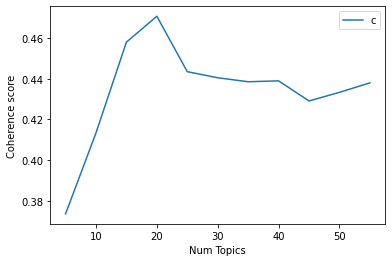

0 Num Topics = 5  has Coherence Value of 0.3735
1 Num Topics = 10  has Coherence Value of 0.4134
2 Num Topics = 15  has Coherence Value of 0.4581
3 Num Topics = 20  has Coherence Value of 0.4708
4 Num Topics = 25  has Coherence Value of 0.4435
5 Num Topics = 30  has Coherence Value of 0.4405
6 Num Topics = 35  has Coherence Value of 0.4386
7 Num Topics = 40  has Coherence Value of 0.439
8 Num Topics = 45  has Coherence Value of 0.4291
9 Num Topics = 50  has Coherence Value of 0.4334
10 Num Topics = 55  has Coherence Value of 0.438


In [10]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=5, limit=60, step=5)

# Show graph to find optimal number of topics
# Coherence value not going flat seems unlikely or probably wrong
limit=60; start=5; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
i = 0
for m, cv in zip(x, coherence_values):
    print(i,"Num Topics =", m, " has Coherence Value of", round(cv, 4))
    i+=1

K = 15 is the optimal number of topics since when

In [11]:
optimal_model = model_list[3] # when number of topics is 15
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.028*"adopting" + 0.025*"revised" + 0.019*"including" + 0.016*"zoning" + '
  '0.015*"expenses" + 0.014*"code" + 0.014*"economic" + 0.014*"service" + '
  '0.013*"workers" + 0.012*"travelling"'),
 (1,
  '0.026*"lot" + 0.021*"ten" + 0.016*"psd" + 0.013*"points" + 0.012*"sworn" + '
  '0.012*"burial" + 0.012*"death" + 0.012*"financial" + 0.012*"assistance" + '
  '0.010*"officials"'),
 (2,
  '0.096*"tax" + 0.067*"code" + 0.041*"known" + 0.039*"article" + '
  '0.036*"chapter" + 0.027*"provided" + 0.015*"adopting" + 0.015*"parking" + '
  '0.015*"revenue" + 0.014*"vocational"'),
 (3,
  '0.033*"purposes" + 0.024*"violations" + 0.024*"installation" + '
  '0.023*"composition" + 0.021*"license" + 0.021*"business" + 0.017*"salary" + '
  '0.016*"establishments" + 0.015*"duties" + 0.014*"descriptions"'),
 (4,
  '0.032*"lot" + 0.031*"area" + 0.028*"tct" + 0.027*"meters" + '
  '0.026*"reclassifying" + 0.025*"square" + 0.025*"zone" + 0.019*"industrial" '
  '+ 0.018*"land" + 0.017*"located"'),
 (

In [12]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.9208,"purposes, violations, installation, compositio...",“AN ORDINANCE REGULATING THE PRACTICE OF TRADI...
1,1,7.0,0.9694,"fees, ord, prescribing, tricycle, mun, collect...",“AN ORDINANCE RECONSTITUTING THE MEMBERS OF TH...
2,2,9.0,0.9050,"appropriating, sangguniang, legislative, thous...",“AN ORDINANCE ESTABLISHING FUNERAL AND BURIAL ...
3,3,17.0,0.3639,"vehicles, school, prohibiting, utility, violat...","AN ORDINANCE AMENDING THE TITLE, SECTION 1, SE..."
4,4,6.0,0.4101,"program, fronting, building, paragraph, prescr...","“AN ORDINANCE CREATING THE CITY HISTORICAL, CU..."
5,5,14.0,0.8812,"amount, mayor, authorizing, augment, thousand,...",“AN ORDINANCE INSTITUTIONALIZING THE HUGPONG S...
6,6,5.0,0.3374,"declaring, portion, street, streets, bonifacio...",“AN ORDINANCE DECLARING THE AREA IN FRONT OF T...
7,7,10.0,0.4255,"market, violation, vendors, regulations, servi...",AN ORDINANCE AMENDING SECTION 2 OF CITY ORDINA...
8,8,17.0,0.4440,"vehicles, school, prohibiting, utility, violat...",AN ORDINANCE GRANTING THE TEMPORARY CLOSURE OF...
9,9,10.0,0.5324,"market, violation, vendors, regulations, servi...",“AN ORDINANCE GRANTING TEMPORARY CLOSURE FROM ...


In [13]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 1000

documents_topic = pd.DataFrame()


sent_topics_sorteddf = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf.head(20)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9648,"adopting, revised, including, zoning, expenses, code, economic, service, workers, travelling","“AN ORDINANCE REQUIRING ALL CONTRACTOR/CONSTRUCTOR UNDERTAKING NATIONAL FUNDED INFRASTRUCTURE PROJECTS IN THE MUNICIPALITY OF TAGUM TO SUBMIT A COPY OF THE PROGRAM OF WORK INCLUDING ITS ENGINEERING DESIGN AND CONTRACT ENTERED INTO BY THE CONTRACTOR/CONSTRUCTOR WITH THE DEPARTMENT OF PUBLIC WORKS AND HIGHWAYS (DPWH) AND ALL OTHER NATIONAL GOVERNMENT AGENCIES TO THE MUNICIPAL MAYOR OF continue reading : MUNICIPAL ORDINANCE NO. 10, s-1991"
1,1.0,0.9661,"lot, ten, psd, points, sworn, burial, death, financial, assistance, officials","“AN ORDINANCE RECLASSIFYING LOT NO. (T-2471) T-633 AND LOT NO. 4-E, PSD-11-024525 ALL OWNED BY JOSE S. GARCIA SITUATED IN MANKILAM, TAGUM, DAVAO, THE FORMER BEING BOUNDED ON THE LINES 1-3 BY PROPERTY OF PAULINO CALAMBA; ALONG LINES 3-6, BY PROPERTY OF MARIANO BELLO; ALONG LINE 6-7 BY PROPERTY OF AMBROCIO FERIDO; AND ALONG LINE continue reading : MUNICIPAL ORDINANCE N0. 21, s-1996"
2,2.0,0.9321,"tax, code, known, article, chapter, provided, adopting, parking, revenue, vocational","“AN ORDINANCE INCREASING THE SLAUGHTER AND CORRAL FEE FOR EVERY LARGE CATTLE, HOG, GOAT, SHEEP AND POULTRY SLAUGHTERED/BUTCHERED AT THE MUNICIPAL ABBATOIR”."
3,3.0,0.9441,"purposes, violations, installation, composition, license, business, salary, establishments, duties, descriptions","“AN ORDINANCE IMPOSING A SERVICE/INSPECTION FEE PER HEAD FOR ALL LARGE CATTLE, HOG, GOAT, SHEEP AND POULTRY/ FOWL TO BE SLAUGHTERED/BUTCHERED AT THE MUNICIPAL ABBATOIR/SLAUGHTERHOUSE”."
4,4.0,0.9661,"lot, area, tct, meters, reclassifying, square, zone, industrial, land, located","“AN ORDINANCE DECLARING THE LANDS STARTING FROM THE FOOT OF HIJO BRIDGE AT BARANGAY APOKON UP TO BARANGAY PANDAPAN, THIS TOWN WITH A WIDTH DISTANCE OF TWO HUNDRED (200) METERS WIDE FROM THE BANKS OF HIJO RIVER AS THE MUNICIPALITY’S HIGHLY POLLUTIVE INDUSTRIAL ZONE BEST SUITED FOR MINERAL PROCESSING INDUSTRIES”."
5,5.0,0.9683,"declaring, portion, street, streets, bonifacio, temporary, year, park, five, clock","“AN ORDINANCE DECLARING A PORTION OF JOSE RIZAL STREET, TAGUM, DAVAO A ONE-WAY STREET EVERY SUNDAY, GOOD FRIDAY, TOWN FIESTA DAY, CHRISTMAS DAY, NEW YEAR’S DAY FROM FIVE O’CLOCK TO TEN O’CLOCK IN THE MORNING (5:00 – 10:00 A.M.) AND FOUR O’CLOCK TO EIGHT O’CLOCK IN THE EVENING (4:00 – 8:00 P.M.) AND PROVIDING PENALTIES continue reading : MUNICIPAL ORDINANCE NO. 77, s-1989"
6,6.0,0.9367,"program, fronting, building, paragraph, prescribing, cultural, education, establishment, historical, zone",“AN ORDINANCE REGULATING THE USE OF OVER-THE-COUNTER DRUGS SUCH AS COUGH PREPARATIONS AND SIMILAR PHARMACEUTICAL PREPARATIONS SUBJECT TO ABUSE AS WELL AS VOLATILE SUBSTANCES AND PRESCRIBING PENALTIES THEREFOR”.
7,7.0,0.9694,"fees, ord, prescribing, tricycle, mun, collection, utility, regulatory, board, per","“AN ORDINANCE RECONSTITUTING THE MEMBERS OF THE CITY TRICYCLE FRANCHISING AND REGULATORY BOARD (CTFRB) PRESCRIBING ITS FUNCTIONS AND PROCEDURES AND PROVIDING MOTORIZED TRICYCLE FOR HIRE (MTH), TRICYCLE UTILITY VEHICLE (TUV) AND TRICYCLE UTILITY FOR HIRE (TUH) GUIDELINES, REGULATIONS AND OPERATIONS, THE COLLECTION OF FEES, CHARGES,ADMINISTRATIVE PROVISIONS AND PROVIDING PENALTIES FOR VIOLATION THEREOF”."
8,8.0,0.9620,"years, video, thereat, increasing, tomb, cemetery, magugpo, coordinating, littering, signboards","“AN ORDINANCE AUTHORIZING THE HOLDING OF THE SPECIAL ELECTIONS FOR THE FOUR (4) NEWLY CREATED BARANGAYS OF MAGUGPO WEST, MAGUGPO EAST, MAGUGPO SOUTH, AND MAGUGPO NORTH ON SEPTEMBER 04, 1994 AS SET BY THE COMELEC EN BANC LAST JULY 26, 1994 AND PROVIDING FUNDS FOR THE PURPOSE”."
9,9.0,0.9661,"appropriating, sangguniang, legislative, thousand, services, iii, panlungsod, purpose, position, staff","“AN ORDINANCE CREATING THE ADDITIONAL POSITION OF ONE (1) LOCAL LEGISLATIVE STAFF OFFICER III OR LLSO III IN 

In [14]:
# df_sorted_by_topic = df_dominant_topic.sort_values(by=['Dominant_Topic'])
# documents with topic 7.0 as dominant topic
df_sorted_by_topic = df_dominant_topic.loc[df_dominant_topic['Dominant_Topic'] == 7.0]

df_sorted_by_topic.head(5)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
1,1,7.0,0.9694,"fees, ord, prescribing, tricycle, mun, collection, utility, regulatory, board, per","“AN ORDINANCE RECONSTITUTING THE MEMBERS OF THE CITY TRICYCLE FRANCHISING AND REGULATORY BOARD (CTFRB) PRESCRIBING ITS FUNCTIONS AND PROCEDURES AND PROVIDING MOTORIZED TRICYCLE FOR HIRE (MTH), TRICYCLE UTILITY VEHICLE (TUV) AND TRICYCLE UTILITY FOR HIRE (TUH) GUIDELINES, REGULATIONS AND OPERATIONS, THE COLLECTION OF FEES, CHARGES,ADMINISTRATIVE PROVISIONS AND PROVIDING PENALTIES FOR VIOLATION THEREOF”."
21,21,7.0,0.8417,"fees, ord, prescribing, tricycle, mun, collection, utility, regulatory, board, per","AN ORDINANCE ESTABLISHING THE BARANGAY AGRI WORKER TO BE KNOWN AS “BAW”, PRESCRIBING GUIDELINES AND PROVIDING FUNDS THEREOF"
67,67,7.0,0.5785,"fees, ord, prescribing, tricycle, mun, collection, utility, regulatory, board, per",“AN ORDINANCE CREATING TAGUM CITY OVERSEAS FILIPINO WORKER (OFW) COORDINATING COUNCIL AND PROVIDING FOR FUNDS THEREOF”.
88,88,7.0,0.9269,"fees, ord, prescribing, tricycle, mun, collection, utility, regulatory, board, per","AN ORDINANCE AMENDING SECTION 4 OF CITY ORDINANCE NO. 616, S-2012 ENTITLED, “AN ORDINANCE APPROVING THE NEW GUIDELINES IN THE GRANTING OF MEDICAL/ SEPARATION/DISABILITY/DEATH BENEFITS TO ALL QUALIFIED BARANGAY HEALTH WORKERS (BHWs) IN TAGUM CITY."
108,108,7.0,0.9587,"fees, ord, prescribing, tricycle, mun, collection, utility, regulatory, board, per","“AN ORDINANCE REVISING THE CREATION OF THE CITY TRICYCLE FRANCHISING AND REGULATORY BOARD (CTFRB) PRESCRIBING ITS FUNCTIONS AND PROCEDURES AND PROVIDING MOTORIZED TRICYCLE FOR HIRE (MTH) GUIDELINES, REGULATIONS AND OPERATIONS, THE COLLECTION OF FEES, CHARGES, ADMINISTRATIVE PROVISIONS AND PROVIDING PENALTIES FOR VIOLATION THEREOF”"


In [15]:
vis = pyLDAvis.gensim_models.prepare(optimal_model, corpus, id2word)
pyLDAvis.display(vis)

/Users/coriv/Developer/Ordinances_LDA/Ordinances_LDA/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


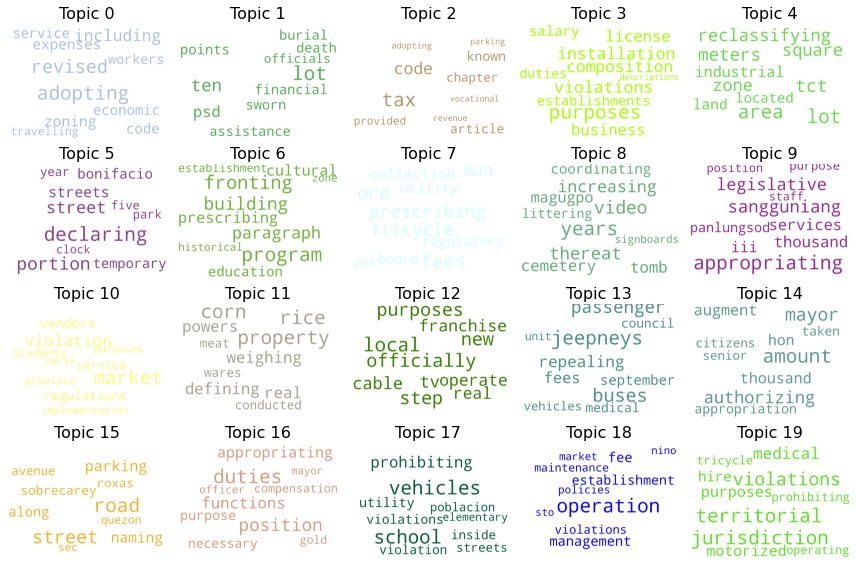

In [16]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.XKCD_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=15,
                  colormap='tab20',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(num_topics=20,formatted=False)

fig, axes = plt.subplots(4, 5, figsize=(12,8), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

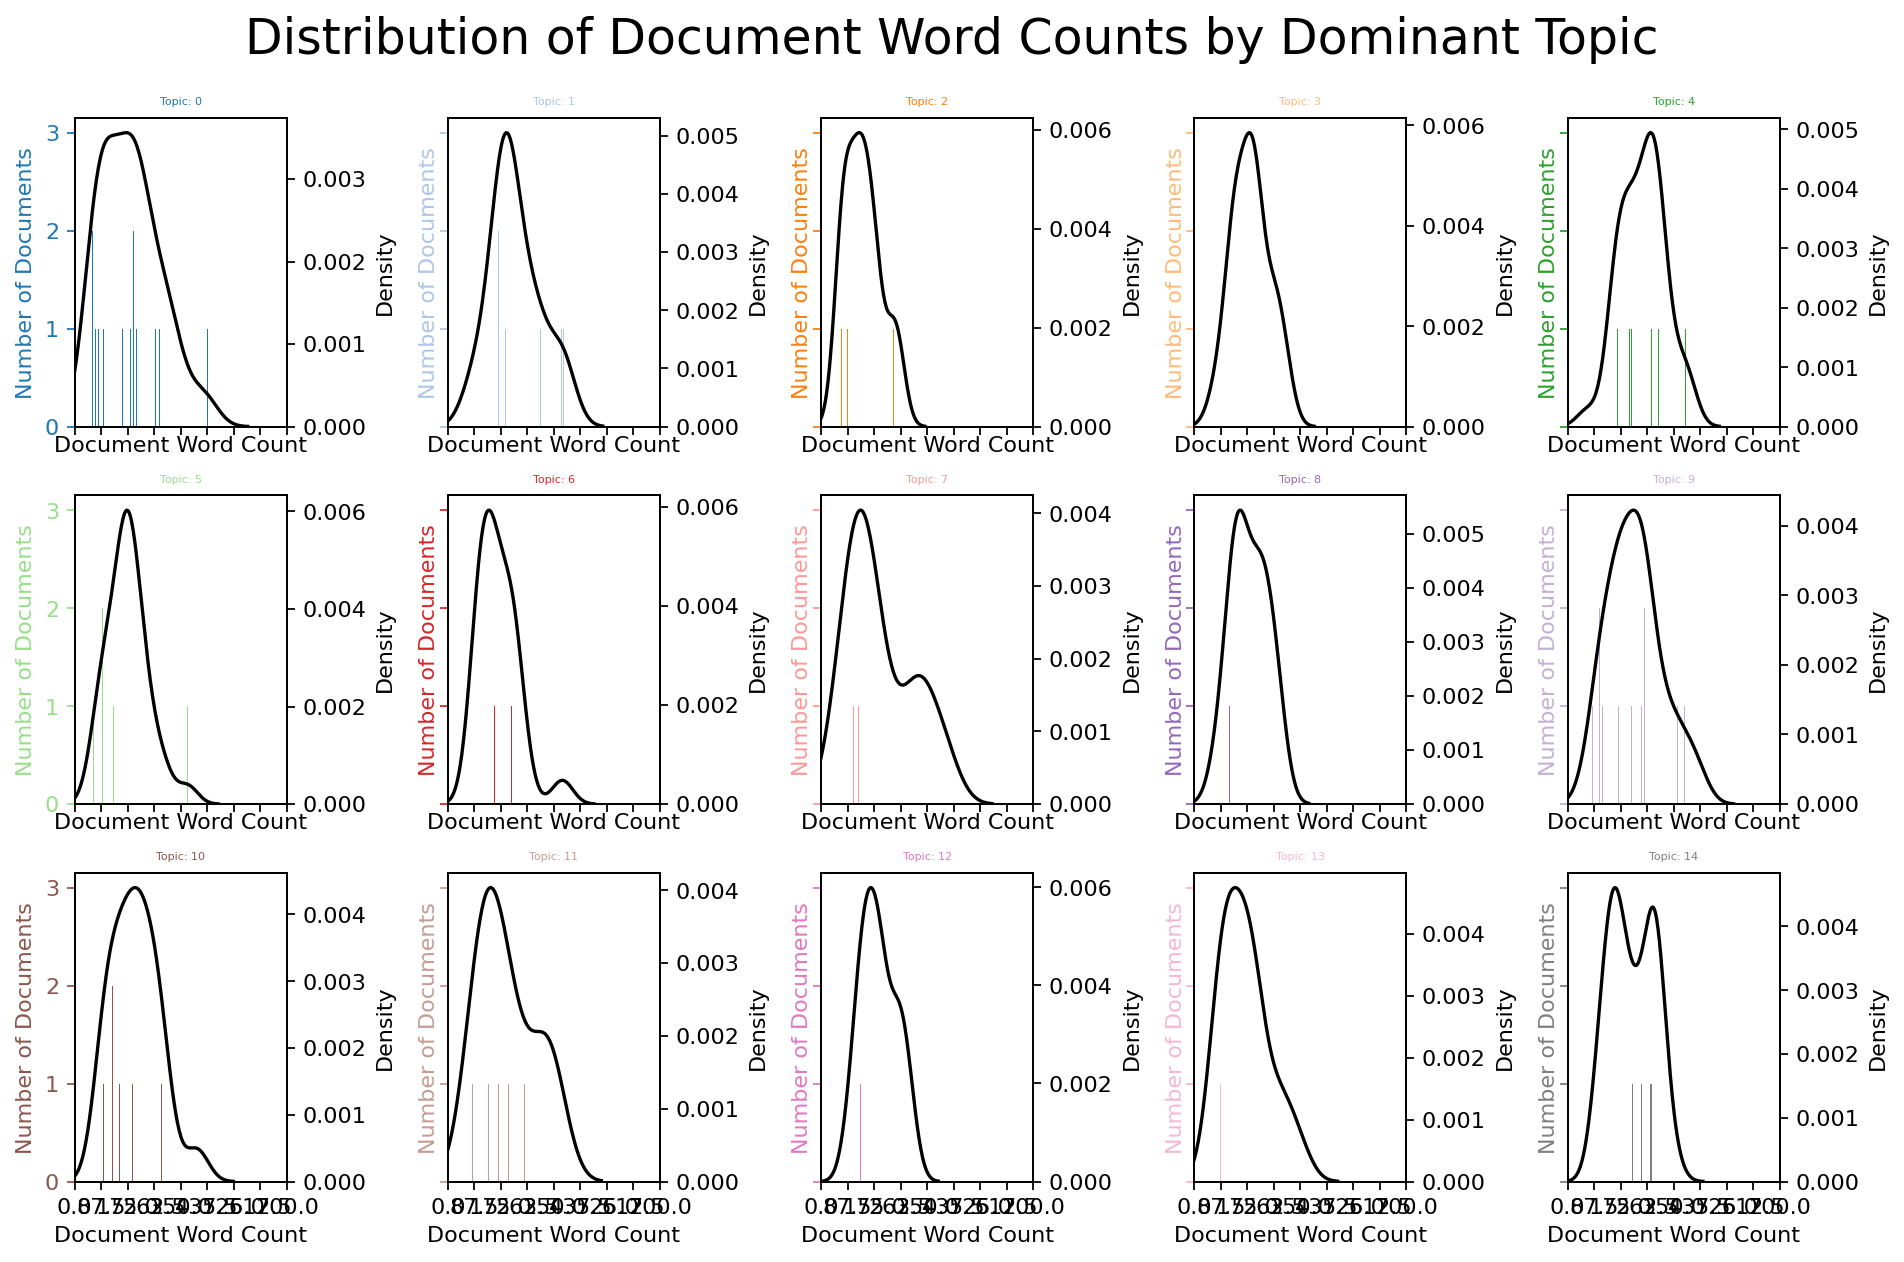

In [17]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(3,5,figsize=(12,8), dpi=160, sharex=True, sharey=True)
# These are the "Tableau 20" colors as RGB.    
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)
    
for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 700, color=tableau20[i])
    ax.tick_params(axis='y', labelcolor=tableau20[i], color=tableau20[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 700), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=tableau20[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=5, color=tableau20[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,700,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

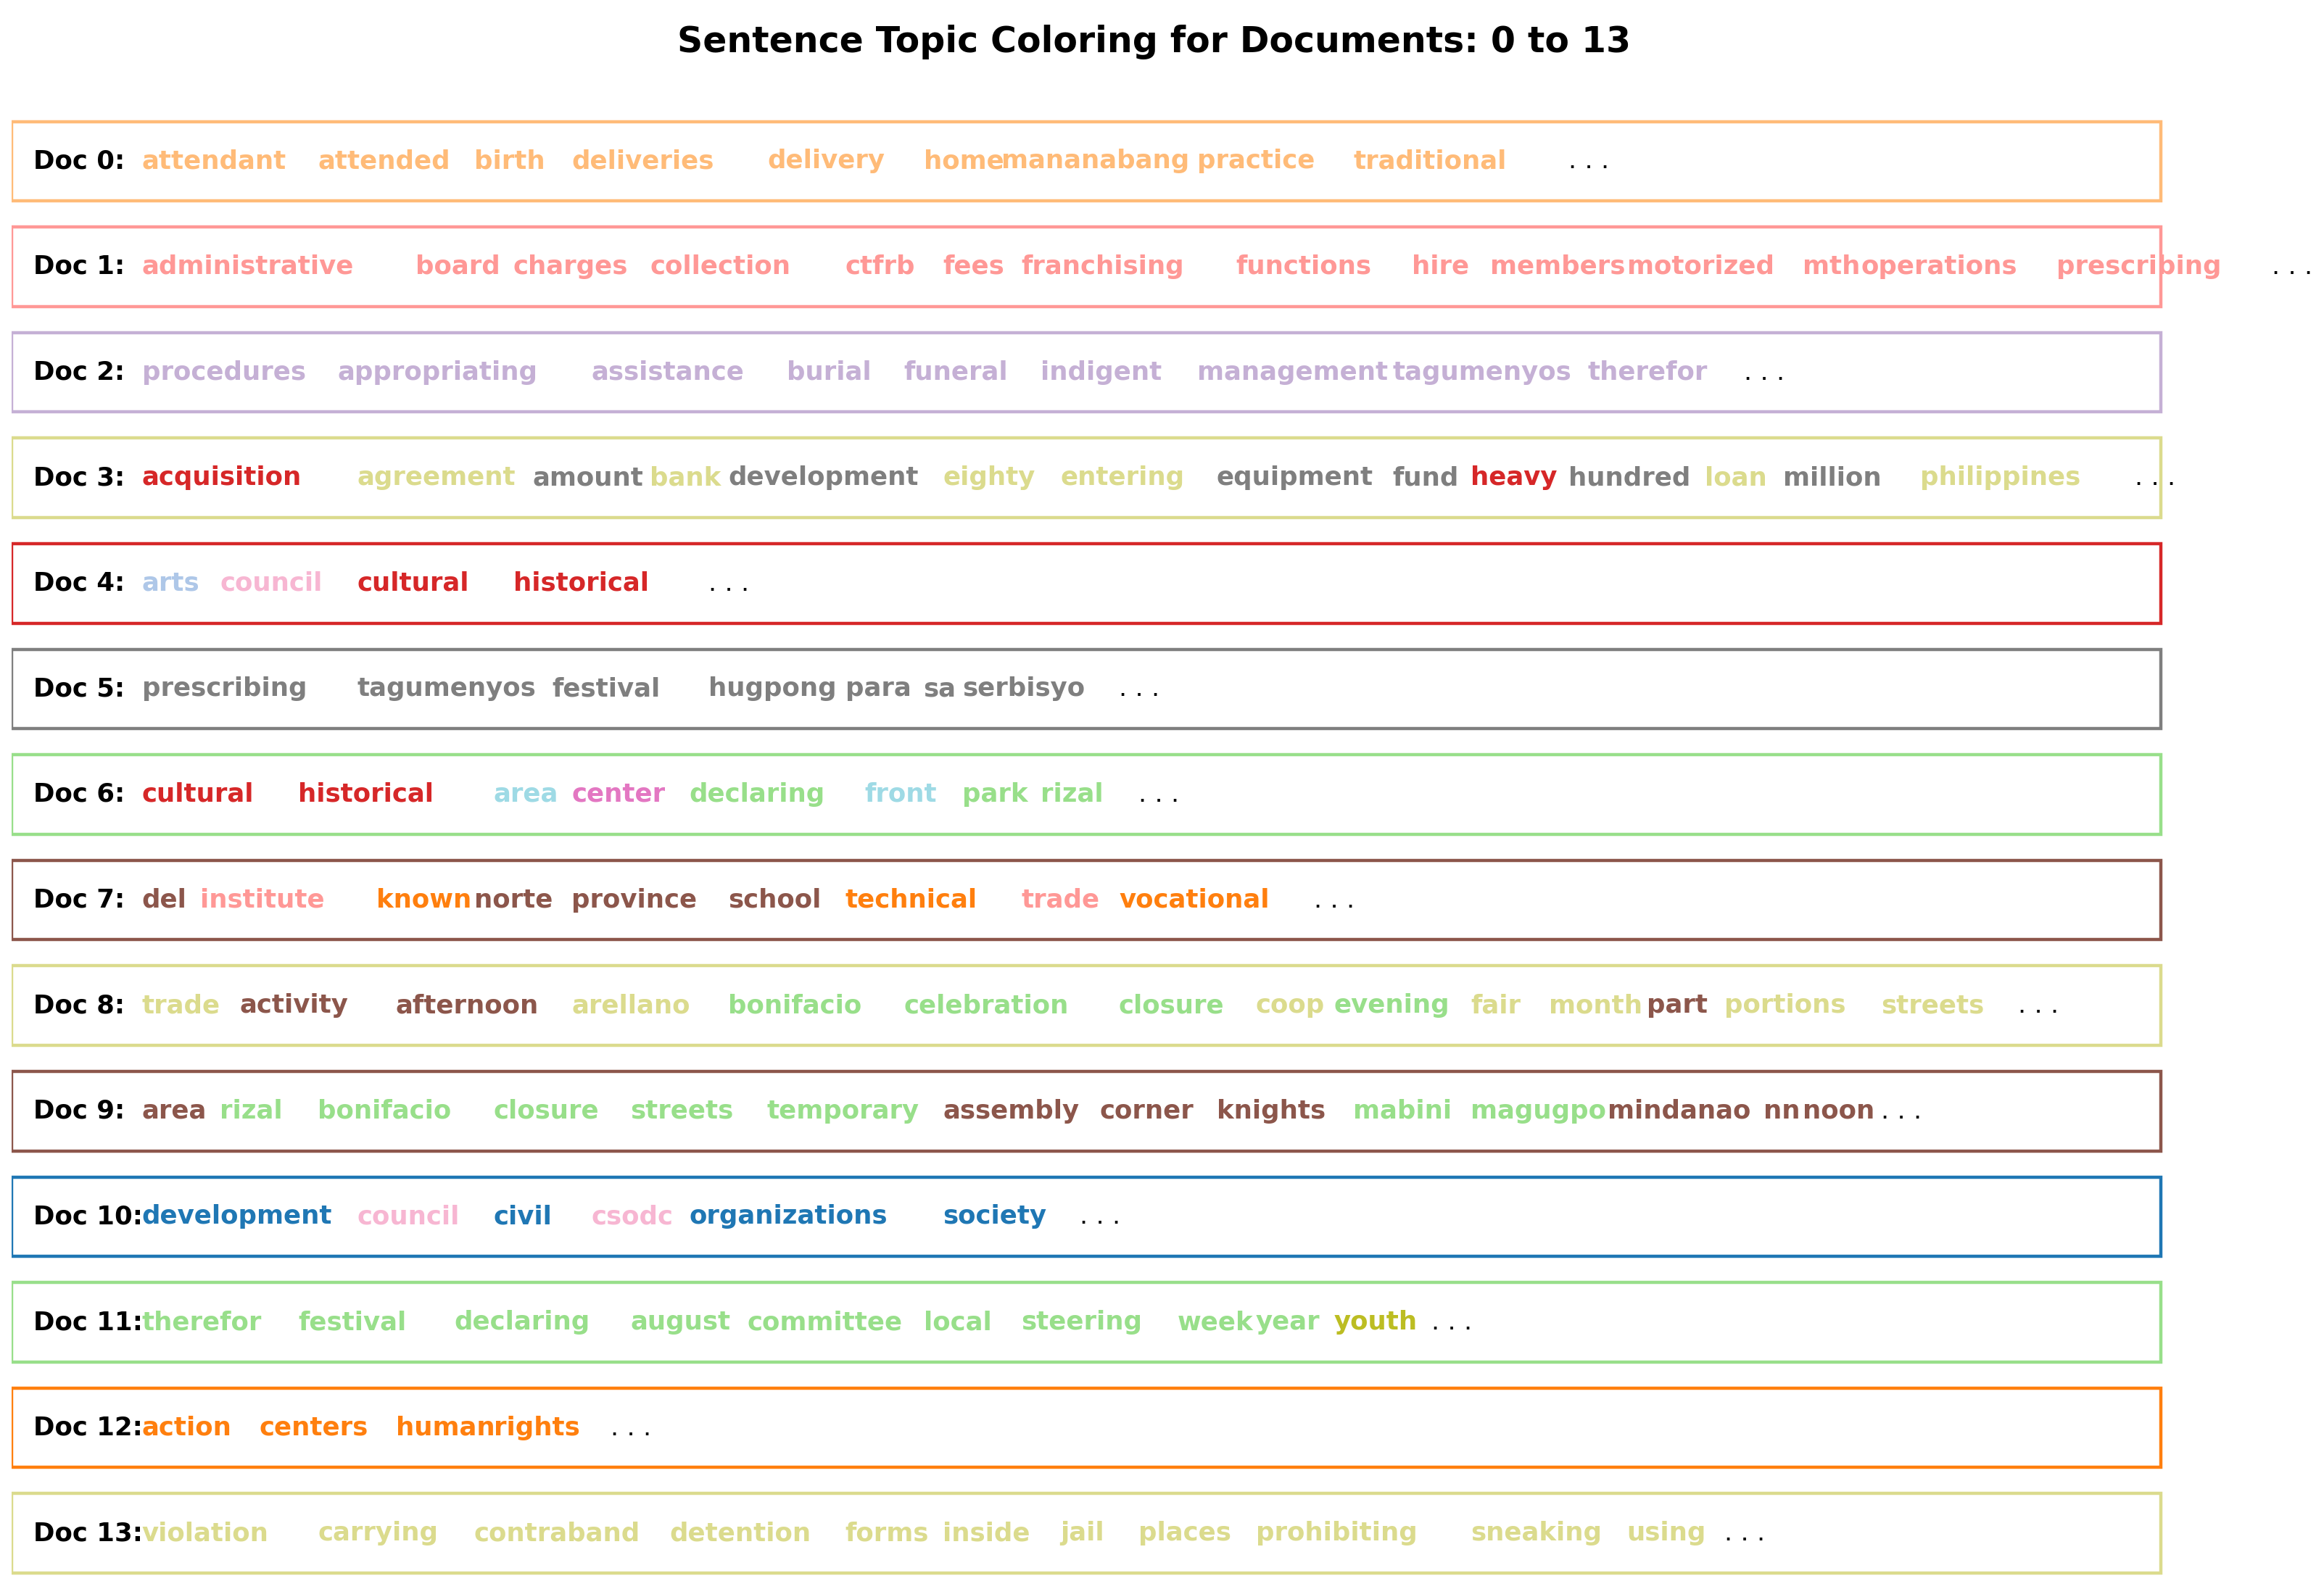

/Users/coriv/Developer/Ordinances_LDA/Ordinances_LDA/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/coriv/Developer/Ordinances_LDA/Ordinances_LDA/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/coriv/Developer/Ordinances_LDA/Ordinances_LDA/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/coriv/Developer/Ordinances_LDA/Ordinances_LDA/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative us

In [18]:

# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=optimal_model, corpus=corpus, start = 0, end = 15):
    corp = corpus[start:end]
    mycolors = tableau20

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()